In [1]:
using Integrals
using SpecialFunctions
using Base.Threads
using Glob
using DataFrames
using CSV
using CairoMakie
using LaTeXStrings
using Polynomials
using Statistics
using PhysicalConstants.CODATA2018
using FilePathsBase
using ColorSchemes
CairoMakie.activate!(inline=true)

In [2]:
CairoMakie.activate!(inline=true)
custom_theme = Theme(
    fontsize = 8,
    linewidth = 1.5,
    fonts = (; regular = "Helvetica"),
    Axis = (
        spinewidth = 1,
        xgridvisible = false,
        ygridvisible = false,
        topspinevisible = false,
        rightspinevisible = false,
        xtickwidth = 1,
        xticksize = 2,
        ytickwidth = 1,
        yticksize = 2,
    ),
    Colorbar = (
        spinewidth = 1,
        tickwidth = 1,
        ticksize = 2,
    ),
    Legend = (
        framevisible = false,
    )
)
set_theme!(custom_theme)

In [3]:
using Unitful
Unitful.preferunits(u"nm")

In [4]:
Unitful.register(@__MODULE__);
@unit b "b" b (0.34)*(45/(45+146))*u"nm" false
@unit kb "kb" kb 1000*u"b" false

┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/GYzMo/src/user.jl:715
┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/GYzMo/src/user.jl:715
┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/GYzMo/src/user.jl:715
┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/GYzMo/src/user.jl:715
┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/GYzMo/src/user.jl:715
┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/GY

kb

In [52]:
# Diffusivity of protein
Dc = 1.0u"μm^2/s"
# Partition ratio c+/c-
Pc = 5
# Diffusivity of RNA
Dm = 0.03u"μm^2/s" 
# Radius of droplet
R = 250 * u"nm"
# Nascent RNA lifetime
lifetime_RNA = uconvert(u"s",10u"minute")
kd = 1/(lifetime_RNA)
# RNA diffusion length
l = sqrt(Dm/kd)
# Contour length of DNA
Lc = uconvert(u"nm",200u"kb")
# Kuhn length of DNA
LK = 35.36u"nm"
# Root mean squared end-to-end vector
rmsd = sqrt(Lc*LK)
# Persistence length of DNA
Lp = LK/2
# Diffusivity of DNA
Dapp = 0.01u"μm^2/s^(1/2)"
De = uconvert(u"μm^2/s",(Dapp/((12/pi)^(1/2)*LK))^2)
# Alpha parameter for DNA
getα(Lc) = 3/(4*Lp*Lc)
getLc(α) = 3/(4*Lp*α)
α = upreferred(getα(Lc))
# Temperature
T = (37 + 273.15)u"K"
# kBT
kBT = BoltzmannConstant*T
# Beta
function getβperkBT(X); return - 3/2 * 1/(Dm*De) * 1/(Pc -1) * l/(4/3*pi*R^3) * X*u"μm^5*s^(-2)"; end
# Production rate
kp = 1u"s^(-1)"

┌ Warning: Symbol kb was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/GYzMo/src/user.jl:715


1 s⁻¹

In [6]:
uconvert(u"b",LK)

┌ Warning: Symbol b was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/GYzMo/src/user.jl:715


441.42222222222216 b

In [7]:
uconvert(u"μm/s",De/LK)

0.5921501690813114 μm s⁻¹

In [8]:
d = 5; R = 2.8; α =1; σ = 2.5; χ = -0.1; Mc = Mm = 1; kp = 0.1; cm = 3.5; cp = 4.5
function f(u,p)
    ϕ₁ = u[1]; r = u[2]; ϕ = u[3]
    R = p[1]; σ = p[2]; d = p[3]; α = p[4]
    return r*R*cos(ϕ)*besselk(0,α*sqrt(R^2+r^2-2*R*r*(cos(ϕ)*cos(ϕ₁)+sin(ϕ)*sin(ϕ₁))))*exp(-(r^2-2*r*cos(ϕ₁)*d+d^2)/(2*σ^2))
end
domain = ([0,0,0], [2*π,Inf,2*π])
p = (R, σ, d, α)
prob = IntegralProblem(f, domain, p)
sol = solve(prob, HCubatureJL(), reltol = 1e-3, abstol = 1e-3)
velocity = (-χ*Mc*kp*cm)/((cp-cm)*π^2*Mm)*sol.u/R^2

0.006229033646333557

In [9]:
function introw(row)
    # Parameters
    Mc = row["Mc"]; Mm = row["Mm"]; χ = row["Chi"]; kp = row["kp"]; kd = row["kd"];
    σ = row["sigma"]; α = row["alpha"]; cplus = row["cplus"]; cminus = row["cminus"];
    # Variables
    R = row["mean_radius"]; d = row["smoothed_distance"]
    # Solution
    b = ([0,0,0], [2*π,Inf,2*π]); p = (R, σ, d, α)
    prob = IntegralProblem(f, b, p)
    sol = solve(prob, HCubatureJL(), reltol = 1e-3, abstol = 1e-3)
    velocity = (-χ*Mc*kp*cminus)/((cplus-cminus)*π^2*Mm)*sol.u/R^2
    return velocity
end

introw (generic function with 1 method)

In [10]:
function introwR(row,R)
    # Parameters
    Mc = row["Mc"]; Mm = row["Mm"]; χ = row["Chi"]; kp = row["kp"]; kd = row["kd"];
    σ = row["sigma"]; α = row["alpha"]; cplus = row["cplus"]; cminus = row["cminus"];
    # Variables
    d = row["smoothed_distance"]
    # Solution
    b = ([0,0,0], [2*π,Inf,2*π]); p = (R, σ, d, α)
    prob = IntegralProblem(f, b, p)
    sol = solve(prob, HCubatureJL(), reltol = 1e-3, abstol = 1e-3)
    velocity = (-χ*Mc*kp*cminus)/((cplus-cminus)*π^2*Mm)*sol.u/R^2
    return velocity
end

introwR (generic function with 1 method)

In [11]:
function intrownormV(row)
    # Parameters
    Mc = row["Mc"]; Mm = row["Mm"]; χ = row["Chi"]; kp = row["kp"]; kd = row["kd"];
    σ = row["sigma"]; α = row["alpha"]; cplus = row["cplus"]; cminus = row["cminus"];
    # Variables
    d = row["smoothed_distance"]
    # Solution
    b = ([0,0,0], [2*π,Inf,2*π]); p = (R, σ, d, α)
    prob = IntegralProblem(f, b, p)
    sol = solve(prob, HCubatureJL(), reltol = 1e-3, abstol = 1e-3)
    velocity = (-χ*Mc*kp*cminus)/((cplus-cminus)*π*Mm)*sol.u
    return velocity
end

intrownormV (generic function with 1 method)

In [12]:
Threads.@threads for stats in glob("20240224_FlowPhaseDiagramHighRes/*/flow_stats_100.csv")
    df = CSV.read(stats, DataFrame)
    df[!,"analytical_velocity"] = map(introw,eachrow(df))
    df[!,"analytical_velocity_normV"] = map(intrownormV,eachrow(df))
    arr = df[!, "mean_radius"]
    avgR = sum(arr)/length(arr)
    df[!,"analytical_velocity_avgR"] = map(row -> introwR(row, avgR),eachrow(df))
    CSV.write(stats, df)
    print("Done. ")
end

Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. 

In [13]:
Threads.@threads for stats in glob("08_FreezeRNA/*/flow_stats_100.csv")
    df = CSV.read(stats, DataFrame)
    df[!,"analytical_velocity"] = map(introw,eachrow(df))
    df[!,"analytical_velocity_normV"] = map(intrownormV,eachrow(df))
    arr = df[!, "mean_radius"]
    avgR = sum(arr)/length(arr)
    df[!,"analytical_velocity_avgR"] = map(row -> introwR(row, avgR),eachrow(df))
    CSV.write(stats, df)
    print("Done. ")
end

Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. Done. 

In [6]:
function velocity3d(z0,R,l)
    function f(u,p)
        x = u[1]
        z0 = p[1]; R = p[2]; l = p[3]
        return x*R^2*exp(-sqrt(R^2+z0^2-2*R*x*z0)/l)/sqrt(R^2+z0^2-2*R*x*z0)
    end
    domain = ([-1], [1])
    p = (z0, R, l)
    prob = IntegralProblem(f, domain, p)
    sol = solve(prob, QuadGKJL(), reltol = 1e-12, abstol = 1e-12)
    velocity = sol.u
    return velocity
end

velocity3d (generic function with 1 method)

┌ Warning: Symbol kb was found in multiple registered unit modules.
│ We will use the one from Main.
└ @ Unitful /Users/wudw/.julia/packages/Unitful/GYzMo/src/user.jl:715


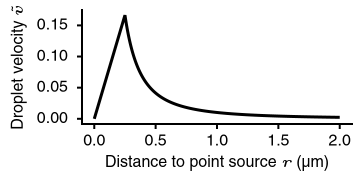

In [7]:
# Diffusivity of protein
Dc = 1.0u"μm^2/s"
# Partition ratio c+/c-
Pc = 5
# Diffusivity of RNA
Dm = 0.03u"μm^2/s" 
# Radius of droplet
R = 250 * u"nm"
# Nascent RNA lifetime
lifetime_RNA = uconvert(u"s",10u"minute")
kd = 1/(lifetime_RNA)
# RNA diffusion length
l = sqrt(Dm/kd)
# Contour length of DNA
Lc = uconvert(u"nm",200u"kb")
# Kuhn length of DNA
LK = 35.36u"nm"
# Root mean squared end-to-end vector
rmsd = sqrt(Lc*LK)
# Persistence length of DNA
Lp = LK/2
# Diffusivity of DNA
Dapp = 0.01u"μm^2/s^(1/2)"
De = uconvert(u"μm^2/s",(Dapp/((12/pi)^(1/2)*LK))^2)
# Alpha parameter for DNA
getα(Lc) = 3/(4*Lp*Lc)
getLc(α) = 3/(4*Lp*α)
α = upreferred(getα(Lc))
# Temperature
T = (37 + 273.15)u"K"
# kBT
kBT = BoltzmannConstant*T
# Beta
function getβperkBT(X); return - 3/2 * 1/(Dm*De) * 1/(Pc -1) * l/(4/3*pi*R^3) * X*u"μm^5*s^(-2)"; end
# Production rate
kp = 1u"s^(-1)"

cm = 28.3465
golden = 1.618
fig = Figure(size = (8.5*1.5cm*0.5, 8.5*1.5cm*0.25),background_color=:transparent, figure_padding=5,
backgroundcolor = :transparent)
ax1 = Axis(fig[1, 1],xlabel=rich("Distance to point source ",rich("r",font="italic")," (μm)"),ylabel=rich("Droplet velocity ",rich("ṽ",font="italic")), backgroundcolor = :transparent)
x = 0:0.001:2
lines!(ax1, x, velocity3d.(x,ustrip(u"μm",R),ustrip(u"μm",l)),color="black")
save("./figures/3dvelocity.pdf",fig,pt_per_unit=1.0,background_color=:transparent,dpi=600)
fig

In [16]:
Makie.theme(:fonts)

Attributes with 4 entries:
  bold => TeX Gyre Heros Makie Bold
  bold_italic => TeX Gyre Heros Makie Bold Italic
  italic => TeX Gyre Heros Makie Italic
  regular => Helvetica

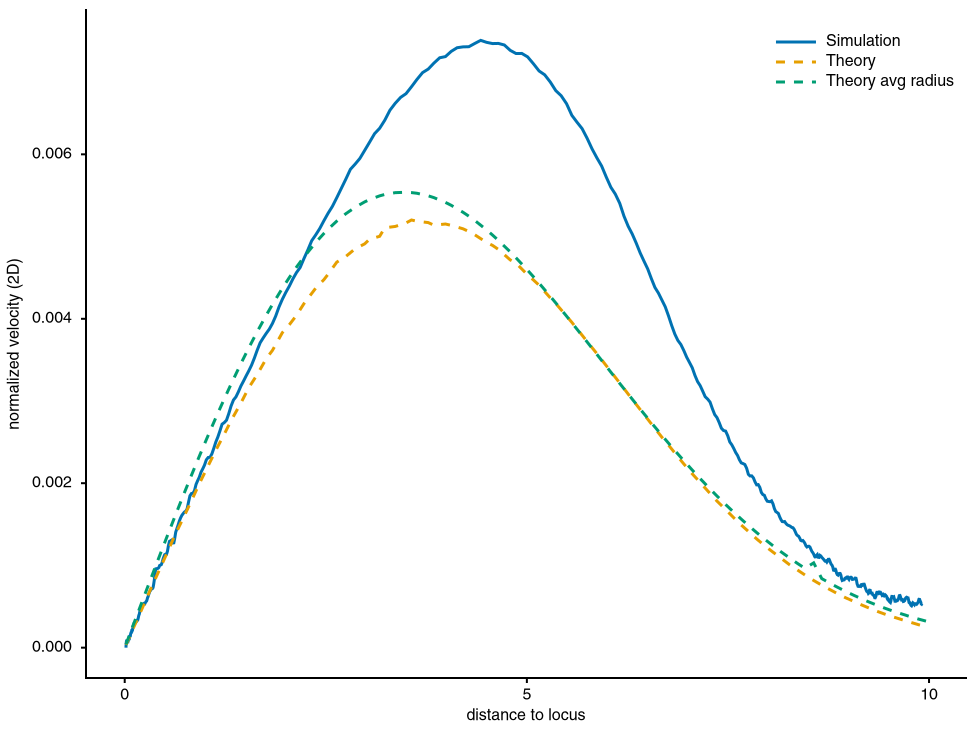

In [17]:
using CairoMakie
using CSV
using DataFrames
using FilePathsBase


prl_col_size_double = 17.2
pt_per_cm = 28.3465
fig = Figure(size = (prl_col_size_double*pt_per_cm*1, prl_col_size_double*pt_per_cm*3/4),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "distance to locus", ylabel = "normalized velocity (2D)")

kp = 0.08
c1 = 3.53

# simdir = Path("08_FreezeRNA")
# simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_6000.0_kd_1.0"
# folder = joinpath(simdir, simtitle)

# # Simulations
# df = DataFrame(CSV.File(joinpath(folder, "flow_stats.csv")))[16:end, :]
# line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity, label="Simulation fixed")

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats.csv")))[16:end, :]
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity, label="Simulation")

# Analytical
flow_stats_df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity, linestyle = :dash, label="Theory")

# Fixed radius
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity_avgR, linestyle = :dash, label="Theory avg radius")


# legend = Legend(fig[1,1], [line1, line2], ["Simulation", "Theory"],framevisible = false,orientation=:horizontal,fontsize=8,padding=[0,0,0,0])
axislegend(ax, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10)
save("./figures/2dvelocity.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

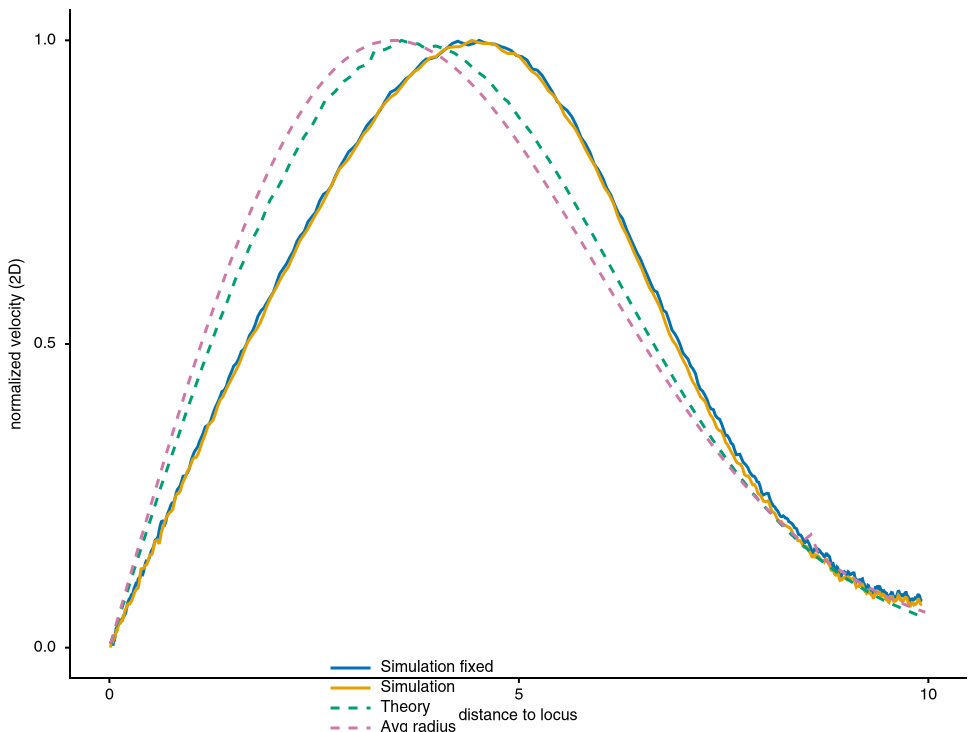

In [18]:
using CairoMakie
using CSV
using DataFrames
using FilePathsBase


prl_col_size_double = 17.2
pt_per_cm = 28.3465
fig = Figure(size = (prl_col_size_double*pt_per_cm*1, prl_col_size_double*pt_per_cm*3/4),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "distance to locus", ylabel = "normalized velocity (2D)")

kp = 0.08
c1 = 3.53

simdir = Path("08_FreezeRNA")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_6000.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats.csv")))[16:end, :]
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity ./maximum(df.smoothed_velocity), label="Simulation fixed")

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats.csv")))[16:end, :]
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity ./maximum(df.smoothed_velocity), label="Simulation")

# Analytical
flow_stats_df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity ./maximum(flow_stats_df.analytical_velocity), linestyle = :dash, label="Theory")

# Fixed radius
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity_avgR ./maximum(flow_stats_df.analytical_velocity_avgR), linestyle = :dash, label="Avg radius")


# legend = Legend(fig[1,1], [line1, line2], ["Simulation", "Theory"],framevisible = false,orientation=:horizontal,fontsize=8,padding=[0,0,0,0])
axislegend(ax, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10, position=(0.35,-0.15))
save("./figures/2dvelocity.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

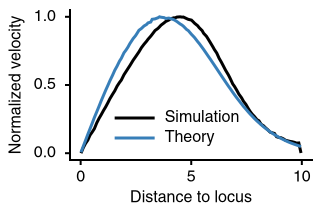

In [19]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm*2/3, 8.5*pt_per_cm*2/3*2/3),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Distance to locus", ylabel = "Normalized velocity")

kp = 0.08
c1 = 3.53

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity/maximum(df.smoothed_velocity), label="Simulation",
color="black")

# Analytical
flow_stats_df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity/maximum(flow_stats_df.analytical_velocity), label="Theory"
,color=ColorSchemes.Set1_3[2])

# # Fixed radius
# line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity_avgR, linestyle = :dash, label="Avg radius")


# legend = Legend(fig[1,1], [line1, line2], ["Simulation", "Theory"],framevisible = false,orientation=:horizontal,fontsize=8,padding=[0,0,0,0])
axislegend(ax, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10, position=(0.35,-0.15))
save("./figures/2dvelocity.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

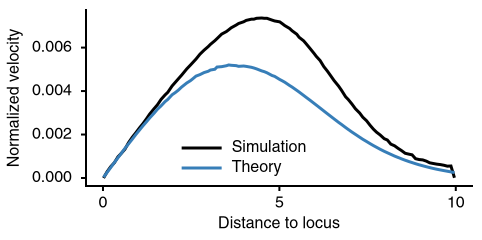

In [20]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm, 8.5*pt_per_cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Distance to locus", ylabel = "Normalized velocity")

kp = 0.08
c1 = 3.53

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity, label="Simulation",
color="black")

# Analytical
flow_stats_df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity, label="Theory"
,color=ColorSchemes.Set1_3[2])

# # Fixed radius
# line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity_avgR, linestyle = :dash, label="Avg radius")


# legend = Legend(fig[1,1], [line1, line2], ["Simulation", "Theory"],framevisible = false,orientation=:horizontal,fontsize=8,padding=[0,0,0,0])
axislegend(ax, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10, position=(0.35,-0.15))
save("./figures/2dvelocity.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

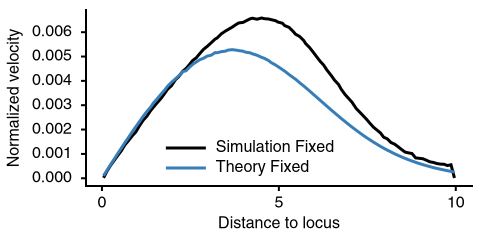

In [21]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm, 8.5*pt_per_cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Distance to locus", ylabel = "Normalized velocity")

kp = 0.08
c1 = 3.53

simdir = Path("08_FreezeRNA")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_6000.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity, label="Simulation Fixed",
color="black")

# Analytical
flow_stats_df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity, label="Theory Fixed"
,color=ColorSchemes.Set1_3[2])

# # Fixed radius
# line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity_avgR, linestyle = :dash, label="Avg radius")


# legend = Legend(fig[1,1], [line1, line2], ["Simulation", "Theory"],framevisible = false,orientation=:horizontal,fontsize=8,padding=[0,0,0,0])
axislegend(ax, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10, position=(0.35,-0.15))
save("./figures/2dvelocity.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

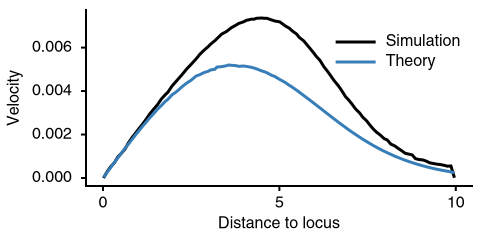

In [22]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm, 8.5*pt_per_cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Distance to locus", ylabel = "Velocity")

kp = 0.08
c1 = 3.53

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity, label="Simulation",
color="black")

# Analytical
flow_stats_df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity, label="Theory",color=ColorSchemes.Set1_3[2])
# line3 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity_avgR, label="Theory Average",color=ColorSchemes.Set1_3[3])
# # Fixed radius
# line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity_avgR, linestyle = :dash, label="Avg radius")

# vlines!(ax,avgR,color=raw"green")

# legend = Legend(fig[1,1], [line1, line2], ["Simulation", "Theory"],framevisible = false,orientation=:horizontal,fontsize=8,padding=[0,0,0,0])
axislegend(ax, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10)
save("./figures/SI_velocitycomparison_fixed.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

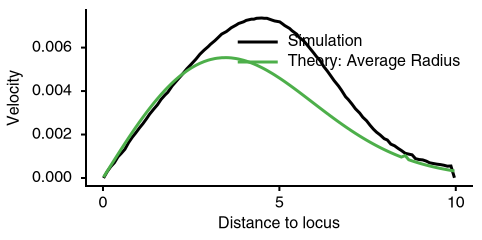

In [23]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm, 8.5*pt_per_cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Distance to locus", ylabel = "Velocity")

kp = 0.08
c1 = 3.53

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity, label="Simulation",
color="black")

# Analytical
flow_stats_df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
# line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity, label="Theory",color=ColorSchemes.Set1_3[2])
line3 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity_avgR, label="Theory: Average Radius",color=ColorSchemes.Set1_3[3])
# # Fixed radius
# line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity_avgR, linestyle = :dash, label="Avg radius")

# vlines!(ax,avgR,color=raw"green")

# legend = Legend(fig[1,1], [line1, line2], ["Simulation", "Theory"],framevisible = false,orientation=:horizontal,fontsize=8,padding=[0,0,0,0])
axislegend(ax, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10)
save("./figures/SI_velocitycomparison_fixed.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

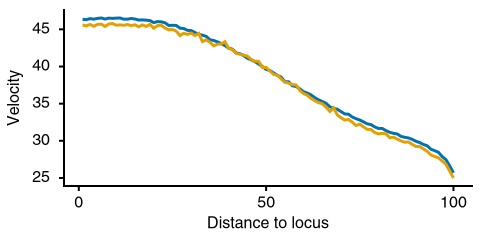

In [24]:
fig = Figure(size = (8.5*pt_per_cm, 8.5*pt_per_cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Distance to locus", ylabel = "Velocity")
lines!(ax,df.volume)
lines!(ax,df.mean_radius .^2 .*pi)
fig

In [25]:
df.time[argmax(df.smoothed_velocity)]

3309.197998046875

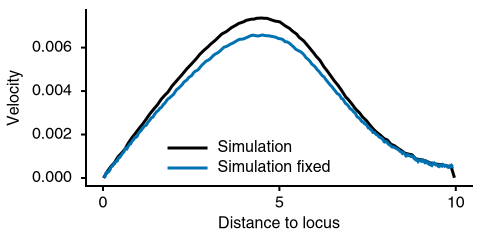

In [26]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm, 8.5*pt_per_cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Distance to locus", ylabel = "Velocity")

kp = 0.08
c1 = 3.53

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity, label="Simulation",
color="black")

simdir = Path("08_FreezeRNA")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_6000.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats.csv")))[16:end, :]
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity, label="Simulation fixed")


# legend = Legend(fig[1,1], [line1, line2], ["Simulation", "Theory"],framevisible = false,orientation=:horizontal,fontsize=8,padding=[0,0,0,0])
axislegend(ax, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10, position=(0.35,-0.15))
save("./figures/SI_velocitycomparison_fixed.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

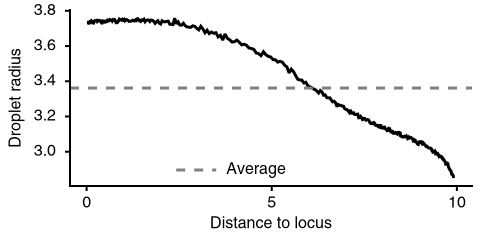

In [27]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm, 8.5*pt_per_cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Distance to locus", ylabel = "Droplet radius")

kp = 0.08
c1 = 3.53

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

line1 = lines!(ax, df.smoothed_distance, df.mean_radius,color="black")
arr = df[!, "mean_radius"]
avgR = sum(arr)/length(arr)
hlines!(ax, avgR,color="grey",linestyle=:dash,label="Average")

axislegend(ax, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10, position=(0.35,-0.15))
save("./figures/2dvelocity_radius.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

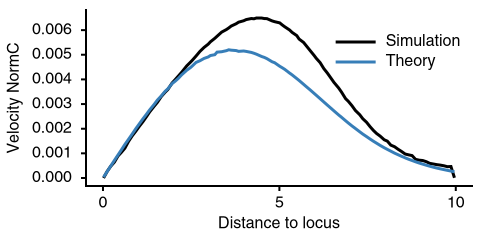

In [28]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm, 8.5*pt_per_cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Distance to locus", ylabel = "Velocity NormC")

kp = 0.08
c1 = 3.53

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity .* (df.c_dense .- df.c_light), label="Simulation",color="black")

# simdir = Path("08_FreezeRNA")
# simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_6000.0_kd_1.0"
# folder = joinpath(simdir, simtitle)

# # Fixed
# df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
# line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity .* (df.c_dense .- df.c_light), label="Simulation Fixed")


# Analytical
flow_stats_df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity .* (df.cplus .- df.cminus), label="Theory",color=ColorSchemes.Set1_3[2])


# legend = Legend(fig[1,1], [line1, line2], ["Simulation", "Theory"],framevisible = false,orientation=:horizontal,fontsize=8,padding=[0,0,0,0])
axislegend(ax, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10)
# save("./figures/2dvelocity_notnormalized.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

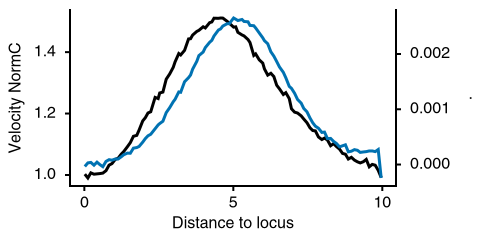

In [29]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm, 8.5*pt_per_cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Distance to locus", ylabel = "Velocity NormC")


kp = 0.08
c1 = 3.53

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line1 = lines!(ax, df.smoothed_distance, df.aspect, label="Simulation",color="black")
ax2 = Axis(fig[1, 1], ylabel=".", backgroundcolor = :transparent, rightspinevisible=true)
hidexdecorations!(ax2)
hidespines!(ax2, :b)
ax2.yaxisposition = :right
lines!(ax2, df.smoothed_distance, (df.smoothed_velocity .- df.analytical_velocity), label="Simulation")


fig

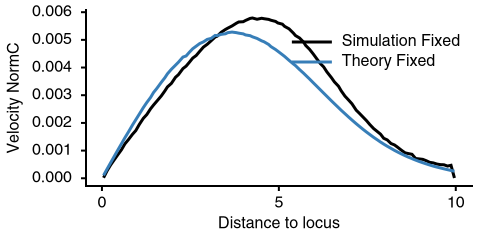

In [30]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm, 8.5*pt_per_cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Distance to locus", ylabel = "Velocity NormC")

kp = 0.08
c1 = 3.53

simdir = Path("08_FreezeRNA")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_6000.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Fixed
df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity .* (df.c_dense .- df.c_light), label="Simulation Fixed", color="black")


# Analytical
line2 = lines!(ax, df.smoothed_distance, df.analytical_velocity .* (df.cplus .- df.cminus), label="Theory Fixed", color=ColorSchemes.Set1_3[2])


# legend = Legend(fig[1,1], [line1, line2], ["Simulation", "Theory"],framevisible = false,orientation=:horizontal,fontsize=8,padding=[0,0,0,0])
axislegend(ax, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10)
# save("./figures/2dvelocity_notnormalized.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

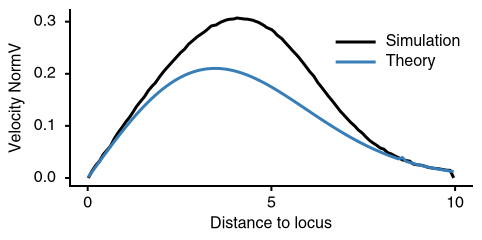

In [31]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm, 8.5*pt_per_cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Distance to locus", ylabel = "Velocity NormV")

kp = 0.08
c1 = 3.53

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# Simulations
df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line1 = lines!(ax, df.smoothed_distance, df.smoothed_velocity .* df.volume, label="Simulation",color="black")
arr = df[!, "mean_radius"]
avgR = sum(arr)/length(arr)

# Analytical
# flow_stats_df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))
line2 = lines!(ax, flow_stats_df.smoothed_distance, flow_stats_df.analytical_velocity_avgR*avgR^2*pi, label="Theory",color=ColorSchemes.Set1_3[2])


# legend = Legend(fig[1,1], [line1, line2], ["Simulation", "Theory"],framevisible = false,orientation=:horizontal,fontsize=8,padding=[0,0,0,0])
axislegend(ax, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10)
# save("./figures/2dvelocity_notnormalized.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

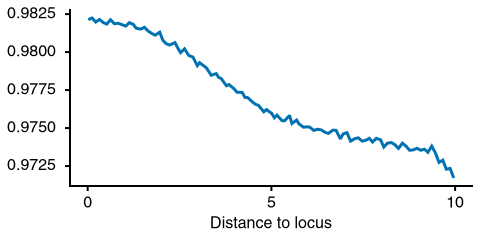

In [32]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm, 8.5*pt_per_cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Distance to locus", ylabel = "")

kp = 0.08
c1 = 3.53

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

lines!(ax, df.smoothed_distance, df.c_dense/4.5)

fig

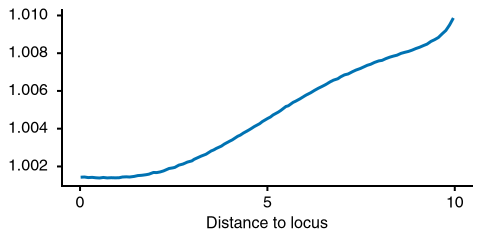

In [33]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm, 8.5*pt_per_cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Distance to locus", ylabel = "")

kp = 0.08
c1 = 3.53

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

lines!(ax, df.smoothed_distance, df.c_light/3.5)
fig

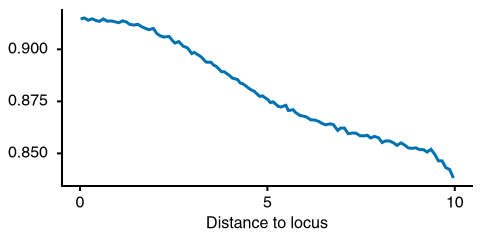

In [34]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm, 8.5*pt_per_cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Distance to locus", ylabel = "")

kp = 0.08
c1 = 3.53

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

lines!(ax, df.smoothed_distance, df.c_dense-df.c_light)

fig

# Production plots

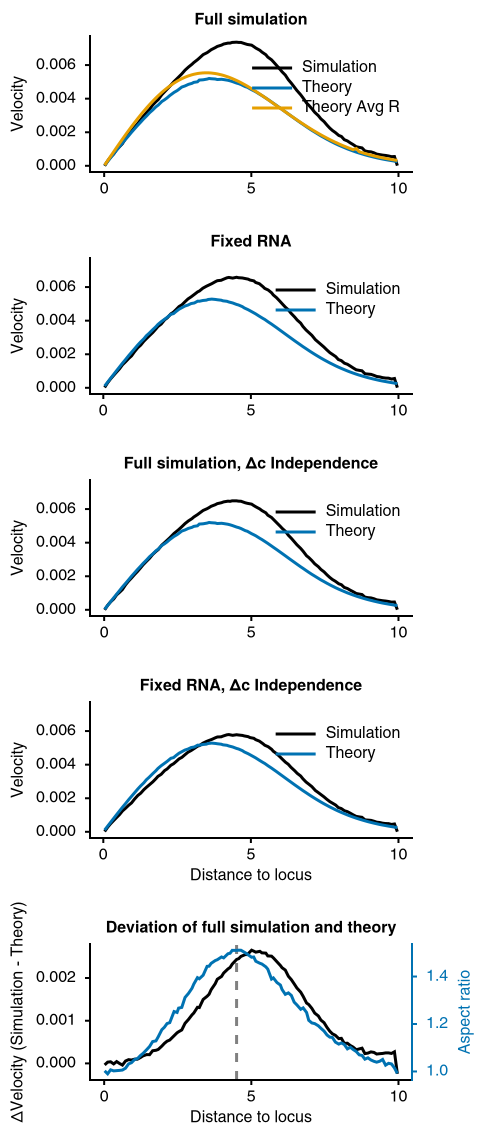

In [35]:
N = 5

pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm, 4*pt_per_cm*N),background_color=:transparent, figure_padding=(5,5,5,5))

kp = 0.08
c1 = 3.53
simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))

simdir_fixed = Path("08_FreezeRNA")
simtitle_fixed = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_6000.0_kd_1.0"
folder_fixed = joinpath(simdir_fixed, simtitle_fixed)

df_fixed = DataFrame(CSV.File(joinpath(folder_fixed, "flow_stats_100.csv")))

ax1 = Axis(fig[1,1], title = "Full simulation", xlabel = "", ylabel = "Velocity")
# Simulations
lines!(ax1, df.smoothed_distance, df.smoothed_velocity, label="Simulation",color="black")
lines!(ax1, df.smoothed_distance, df.analytical_velocity, label="Theory",color=Makie.wong_colors()[1])
lines!(ax1, df.smoothed_distance, df.analytical_velocity_avgR, label="Theory Avg R",color=Makie.wong_colors()[2])
axislegend(ax1, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10)

ax2 = Axis(fig[2,1], title = "Fixed RNA", xlabel = "", ylabel = "Velocity")
lines!(ax2, df_fixed.smoothed_distance, df_fixed.smoothed_velocity, label="Simulation",color="black")
lines!(ax2, df_fixed.smoothed_distance, df_fixed.analytical_velocity, label="Theory",color=Makie.wong_colors()[1])
# lines!(ax2, df_fixed.smoothed_distance, df_fixed.analytical_velocity_avgR, label="Theory AvgR",color=Makie.wong_colors()[2])
axislegend(ax2, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10)

ax3 = Axis(fig[3,1], title = "Full simulation, Δc Independence", xlabel = "", ylabel = "Velocity")
lines!(ax3, df.smoothed_distance, df.smoothed_velocity .* (df.c_dense .- df.c_light), label="Simulation",color="black")
lines!(ax3, df.smoothed_distance, df.analytical_velocity .* (df.cplus .- df.cminus), label="Theory",color=Makie.wong_colors()[1])
axislegend(ax3, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10)

ax4 = Axis(fig[4,1], title = "Fixed RNA, Δc Independence", xlabel = "Distance to locus", ylabel = "Velocity")
lines!(ax4, df_fixed.smoothed_distance, df_fixed.smoothed_velocity .* (df_fixed.c_dense .- df_fixed.c_light), label="Simulation",color="black")
lines!(ax4, df_fixed.smoothed_distance, df_fixed.analytical_velocity .* (df_fixed.cplus .- df_fixed.cminus), label="Theory",color=Makie.wong_colors()[1])
axislegend(ax4, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10)

ax5 = Axis(fig[5,1], title = "Deviation of full simulation and theory", xlabel = "Distance to locus", ylabel = "ΔVelocity (Simulation - Theory)")
lines!(ax5, df.smoothed_distance, df.smoothed_velocity - df.analytical_velocity,color="black")
vlines!(ax5,df.smoothed_distance[argmax(df.smoothed_velocity)], color="grey", linestyle=:dash)
ax5_2 = Axis(fig[5, 1], ylabel="Aspect ratio", backgroundcolor = :transparent, rightspinevisible=true,
rightspinecolor=Makie.wong_colors()[1],
ylabelcolor=Makie.wong_colors()[1],
ytickcolor=Makie.wong_colors()[1],
yticklabelcolor=Makie.wong_colors()[1])
hidexdecorations!(ax5_2)
hidespines!(ax5_2, :b)
ax5_2.yaxisposition = :right
lines!(ax5_2, df.smoothed_distance, df.aspect, label="Simulation",color=Makie.wong_colors()[1])

linkyaxes!(ax1,ax2,ax3,ax4)

fig

In [36]:
max3 = maximum(df_fixed.analytical_velocity ./ (df_fixed.c_dense .- df_fixed.c_light))
max4 = maximum(df.analytical_velocity)
max2 = maximum(df_fixed.smoothed_velocity)
max1 = maximum(df.smoothed_velocity)

0.007361621960880055

In [37]:
max1/max4  # Simulation is greater than simulation by 41.5%

1.415404072032774

In [38]:
1-max4/max1  # Theory underpredicts simulation by 29.3%

0.2934879729688634

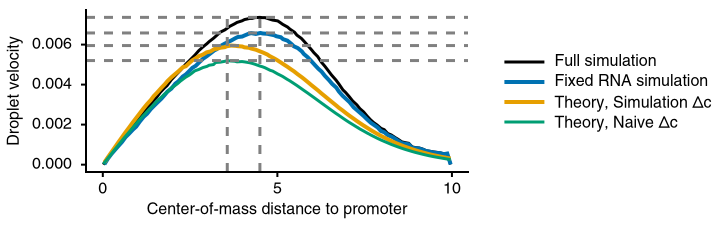

In [39]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm*1.5, 4*pt_per_cm),background_color=:transparent, figure_padding=(5,5,5,5))

kp = 0.08
c1 = 3.53
simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))

simdir_fixed = Path("08_FreezeRNA")
simtitle_fixed = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_6000.0_kd_1.0"
folder_fixed = joinpath(simdir_fixed, simtitle_fixed)

df_fixed = DataFrame(CSV.File(joinpath(folder_fixed, "flow_stats_100.csv")))


ax1 = Axis(fig[1,1], title = "", xlabel = "Center-of-mass distance to promoter", ylabel = "Droplet velocity")
# Simulations
l1 = lines!(ax1, df.smoothed_distance, df.smoothed_velocity,color="black")
l2 = lines!(ax1, df_fixed.smoothed_distance, df_fixed.smoothed_velocity,linewidth=2)
vlines!(ax1,df.smoothed_distance[argmax(df_fixed.smoothed_velocity)],color="grey",linestyle=:dash)
l3 = lines!(ax1, df_fixed.smoothed_distance, df_fixed.analytical_velocity ./ (df_fixed.c_dense .- df_fixed.c_light),linewidth=2)
l4 = lines!(ax1, df.smoothed_distance, df.analytical_velocity)
vlines!(ax1,df.smoothed_distance[argmax(df.analytical_velocity)], color="grey",linestyle=:dash)

hlines!(ax1,[max1,max2,max3,max4], color="grey",linestyle=:dash)

# axislegend(ax1, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10)

Legend(fig[1,2],
[l1,l2,l3,l4],
["Full simulation","Fixed RNA simulation","Theory, Simulation Δc","Theory, Naive Δc"],
fontsize=8,
framevisible=false,
padding=[0,0,0,0],
rowgap=-10
)

save("./figures/SI_VelocityDissect.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

In [40]:
df.smoothed_distance[argmax(df_fixed.smoothed_velocity)]/df.smoothed_distance[argmax(df.analytical_velocity)] - 1

0.2621080473727424

In [41]:
max3 = maximum(df_fixed.analytical_velocity ./ (df_fixed.c_dense .- df_fixed.c_light))
max4 = maximum(df.analytical_velocity)
max2 = maximum(df_fixed.smoothed_velocity)
max1 = maximum(df.smoothed_velocity)

0.007361621960880055

In [42]:
max1/max4 - 1

0.4154040720327741

In [43]:
max2/max4 - 1

0.2655829353619943

In [44]:
max3/max4 - 1

0.14461258788496423

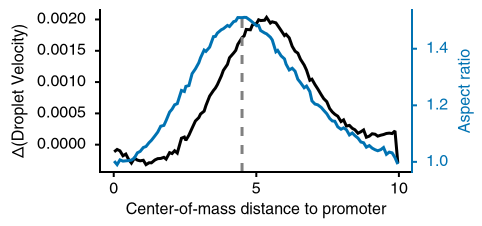

In [45]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm, 4*pt_per_cm),background_color=:transparent, figure_padding=(5,5,5,5))

kp = 0.08
c1 = 3.53
simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

df = DataFrame(CSV.File(joinpath(folder, "flow_stats_100.csv")))

simdir_fixed = Path("08_FreezeRNA")
simtitle_fixed = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_6000.0_kd_1.0"
folder_fixed = joinpath(simdir_fixed, simtitle_fixed)

df_fixed = DataFrame(CSV.File(joinpath(folder_fixed, "flow_stats_100.csv")))


ax1 = Axis(fig[1,1], title = "", xlabel = "Center-of-mass distance to promoter", ylabel = "Δ(Droplet Velocity)")
# Simulations
l1 = lines!(ax1, df.smoothed_distance, df.smoothed_velocity .-df_fixed.analytical_velocity ./ (df_fixed.c_dense .- df_fixed.c_light),color="black")
# l2 = lines!(ax1, df_fixed.smoothed_distance, df_fixed.smoothed_velocity .-df_fixed.analytical_velocity ./ (df_fixed.c_dense .- df_fixed.c_light),linewidth=2)
# hlines!(ax1,0,color="grey",linestyle=:dash)

ax1_2 = Axis(fig[1, 1], ylabel="Aspect ratio", backgroundcolor = :transparent, rightspinevisible=true,
rightspinecolor=Makie.wong_colors()[1],
ylabelcolor=Makie.wong_colors()[1],
ytickcolor=Makie.wong_colors()[1],
yticklabelcolor=Makie.wong_colors()[1])
hidexdecorations!(ax1_2)
hidespines!(ax1_2, :b)
ax1_2.yaxisposition = :right
lines!(ax1_2, df.smoothed_distance, df.aspect,color=Makie.wong_colors()[1])
vlines!(ax1_2, df.smoothed_distance[argmax(df.smoothed_velocity)],color="grey",linestyle=:dash)

# axislegend(ax1, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10)

# Legend(fig[1,2],
# [l1,l2],
# ["Full simulation – Theory, Simulation Δc","Fixed RNA simulation – Theory, Simulation Δc"],
# fontsize=8,
# framevisible=false,
# padding=[0,0,0,0],
# rowgap=-10
# )
save("./figures/SI_VelocityDeviation.pdf",fig,pt_per_unit=1.0,background_color=:transparent)

fig

In [46]:
df.smoothed_velocity

100-element Vector{Float64}:
 6.125257111532639e-7
 0.0002921928023707056
 0.0005203646988067388
 0.0007046796851366971
 0.000974878909829769
 0.0011364234390731157
 0.00132164634148111
 0.0016300964906728888
 0.001874827642683874
 0.0020734518100014587
 ⋮
 0.0007762671799892429
 0.0007001878683282614
 0.0006670005896637909
 0.0006379841234480099
 0.0006181387285290052
 0.0005868981657433103
 0.0005452033235529563
 0.0005529222445225801
 1.0648312832195472e-5

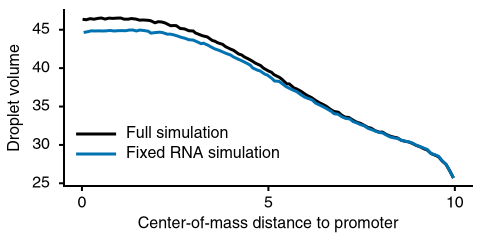

In [47]:
fig = Figure(size = (8.5*pt_per_cm, 8.5*pt_per_cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Center-of-mass distance to promoter", ylabel = "Droplet volume")
l1 = lines!(ax,df.smoothed_distance,df.volume,label="Full simulation",color="black")
l2 = lines!(ax,df_fixed.smoothed_distance,df_fixed.volume,label="Fixed RNA simulation")
axislegend(ax,fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10, halign=:left, valign=:bottom)
save("./figures/SI_Volume.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

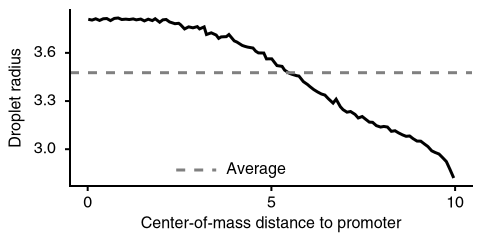

In [48]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm, 8.5*pt_per_cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Center-of-mass distance to promoter", ylabel = "Droplet radius")

kp = 0.08
c1 = 3.53

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

line1 = lines!(ax, df.smoothed_distance, df.mean_radius,color="black")
arr = df[!, "mean_radius"]
avgR = sum(arr)/length(arr)
hlines!(ax, avgR,color="grey",linestyle=:dash,label="Average")

axislegend(ax, fontsize = 8,framevisible = false, padding=[0,0,0,0], rowgap = -10, position=(0.35,-0.15))
save("./figures/SI_Radius.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig

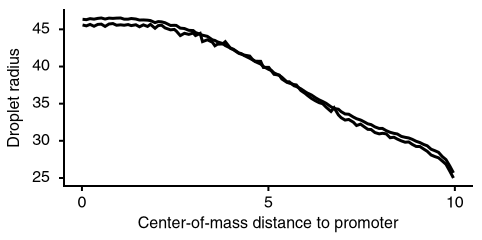

In [49]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm, 8.5*pt_per_cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Center-of-mass distance to promoter", ylabel = "Droplet radius")

kp = 0.08
c1 = 3.53

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

line1 = lines!(ax, df.smoothed_distance, df.mean_radius .^2 .*pi,color="black")
line1 = lines!(ax, df.smoothed_distance, df.volume,color="black")
arr = df[!, "mean_radius"]
avgR = sum(arr)/length(arr)
# hlines!(ax, avgR,color="grey",linestyle=:dash,label="Average")

fig

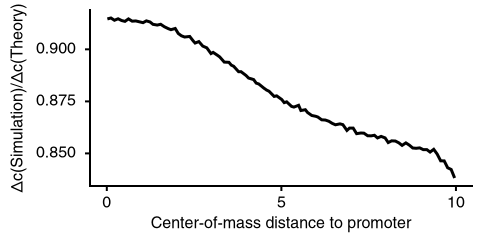

In [50]:
pt_per_cm = 28.3465
fig = Figure(size = (8.5*pt_per_cm, 8.5*pt_per_cm/2),background_color=:transparent, figure_padding=(5,5,5,5))
ax = Axis(fig[1,1], title = "", xlabel = "Center-of-mass distance to promoter", ylabel = "Δc(Simulation)/Δc(Theory)")

kp = 0.08
c1 = 3.53

simdir = Path("20240224_FlowPhaseDiagramHighRes")
simtitle = "M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_$(kp)_c1_$(c1)_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_0.0_kd_1.0"
folder = joinpath(simdir, simtitle)

# l1 = lines!(ax, df.smoothed_distance, df.c_dense/4.5, label="(Within droplet)/4.5")
# l2 = lines!(ax, df.smoothed_distance, df.c_light/3.5, label="(Outside droplet)/3.5")
l3 = lines!(ax, df.smoothed_distance, (df.c_dense-df.c_light)/1, label="Δc/1",color="black")

# Legend(fig[1,2],
# [l3],
# # [rich("(Within droplet)/4.5"),"(Outside droplet)/3.5","(Within-Outside Droplet)/(4.5-3.5)"],
# ["Δc(Simulation)/Δc(Theory)"],
# fontsize=8,
# framevisible=false,
# padding=[0,0,0,0],
# # rowgap=-10
# )

save("./figures/SI_Protein.pdf",fig,pt_per_unit=1.0,background_color=:transparent)
fig